# Import Packages and Load Dataset

In [1]:
# import relevant packages
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import ARIMA, auto_arima
from statsmodels.tsa.api import VAR

# update the path to the project folder
import sys
import os
project_path = os.path.abspath(os.path.join(os.path.dirname(os.getcwd()), ''))
sys.path.append(project_path)

# import py from src folder
from src.data_processing import data_preparation
from src.model import adfuller_test, grangers_causation_test, invert_differentiation, evaluate_forecast
from src.visualization import price_time_series_plot, production_consumption_time_series_plot

In [2]:
import warnings
warnings.filterwarnings("ignore")

In this notebook, our goal is to create a forecast model for the 'Europe Brent Oil Price' value. Also, we include several external variables to assess whether they have a causal relationship with the target variable. We incorporate regional production and consumption data, as these factors are important in influencing oil prices by shaping global supply and demand dynamics. By analyzing the production and consumption trends in different regions, we will assess which region has a more significant impact on the Brent Oil Price, which could be utilized to improve the forecast model.

In [3]:
# load dataset
# target value to forecast
brent_oil_price = pd.read_csv(project_path+'/data/brent_crude_oil_price.csv', sep=",",skiprows=4)
# external variable
wti_oil_price = pd.read_csv(project_path+'/data/wti_crude_oil_price.csv', sep=",",skiprows=4)
europe_production = pd.read_csv(project_path+'/data/europe_petroleum_production.csv', sep=",",skiprows=4)
europe_consumption = pd.read_csv(project_path+'/data/europe_petroleum_consumption.csv', sep=",",skiprows=4)
us_production = pd.read_csv(project_path+'/data/us_petroleum_production.csv', sep=",",skiprows=4)
us_consumption = pd.read_csv(project_path+'/data/us_petroleum_consumption.csv', sep=",",skiprows=4)
africa_production = pd.read_csv(project_path+'/data/africa_petroleum_production.csv', sep=",",skiprows=4)
africa_consumption = pd.read_csv(project_path+'/data/africa_petroleum_consumption.csv', sep=",",skiprows=4)

We begin the forecast with preparing the loaded dataset by dropping the projected values (2025 onwards) and aligning each dataset to the same timeframe by setting 2000 as the starting point.

In [4]:
# cleansing for each dataset
brent_oil_price_univariate = data_preparation(brent_oil_price) 

# for multivariate each dataset need to be in the same time frame
brent_oil_price_multivariate = data_preparation(brent_oil_price, True, True)
wti_oil_price = data_preparation(wti_oil_price, True) 
europe_production = data_preparation(europe_production, True)
europe_consumption = data_preparation(europe_consumption, True) 
us_production = data_preparation(us_production, True) 
us_consumption = data_preparation(us_consumption, True) 
africa_production = data_preparation(africa_production, True) 
africa_consumption = data_preparation(africa_consumption, True) 

Here, we visualize the data with a line plot to gain a better understanding of each variable and observe the trends and seasonality in the dataset.

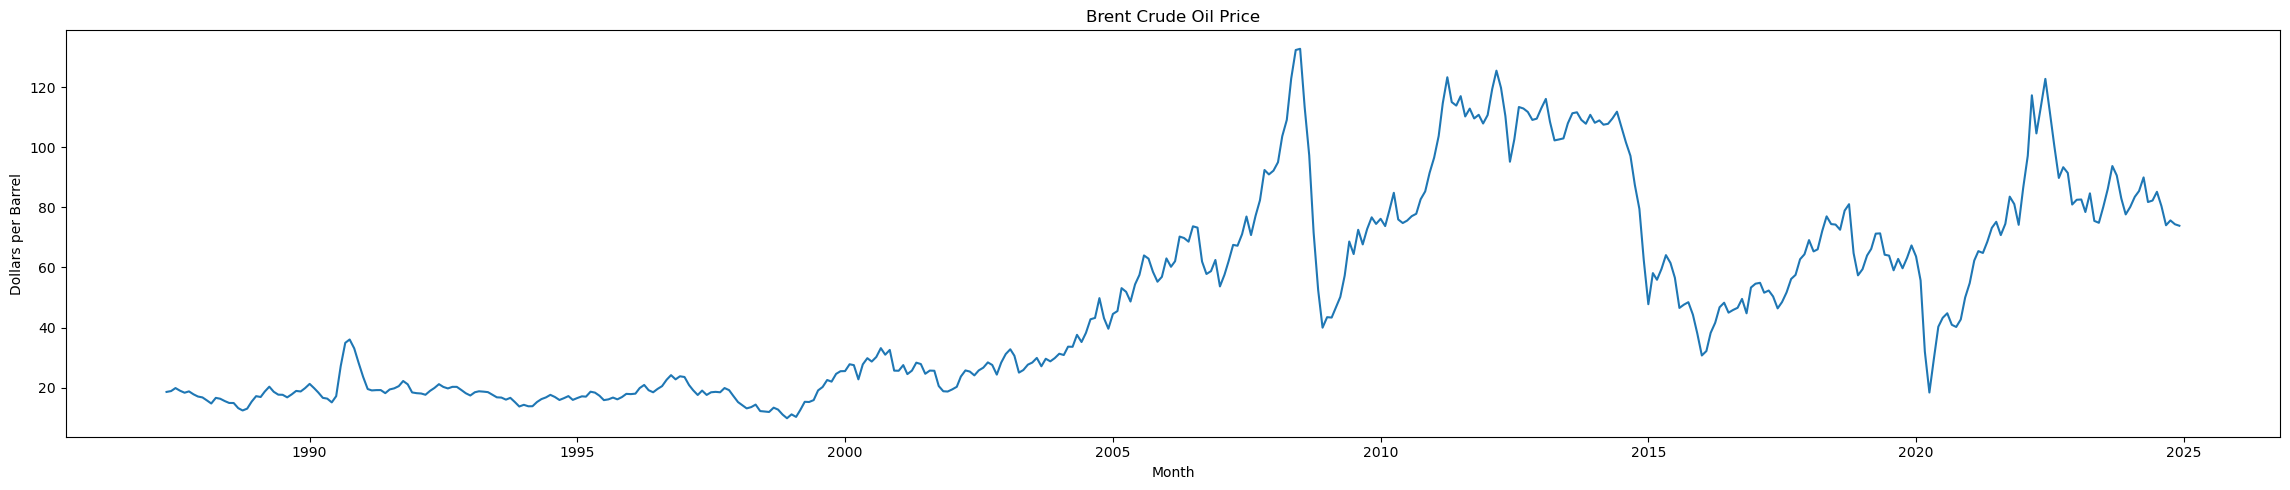

<Figure size 2500x700 with 0 Axes>

In [5]:
price_time_series_plot(brent_oil_price,'Europe Brent Spot Price FOB Dollars per Barrel', 'Dollars per Barrel', 'Brent Crude Oil Price')

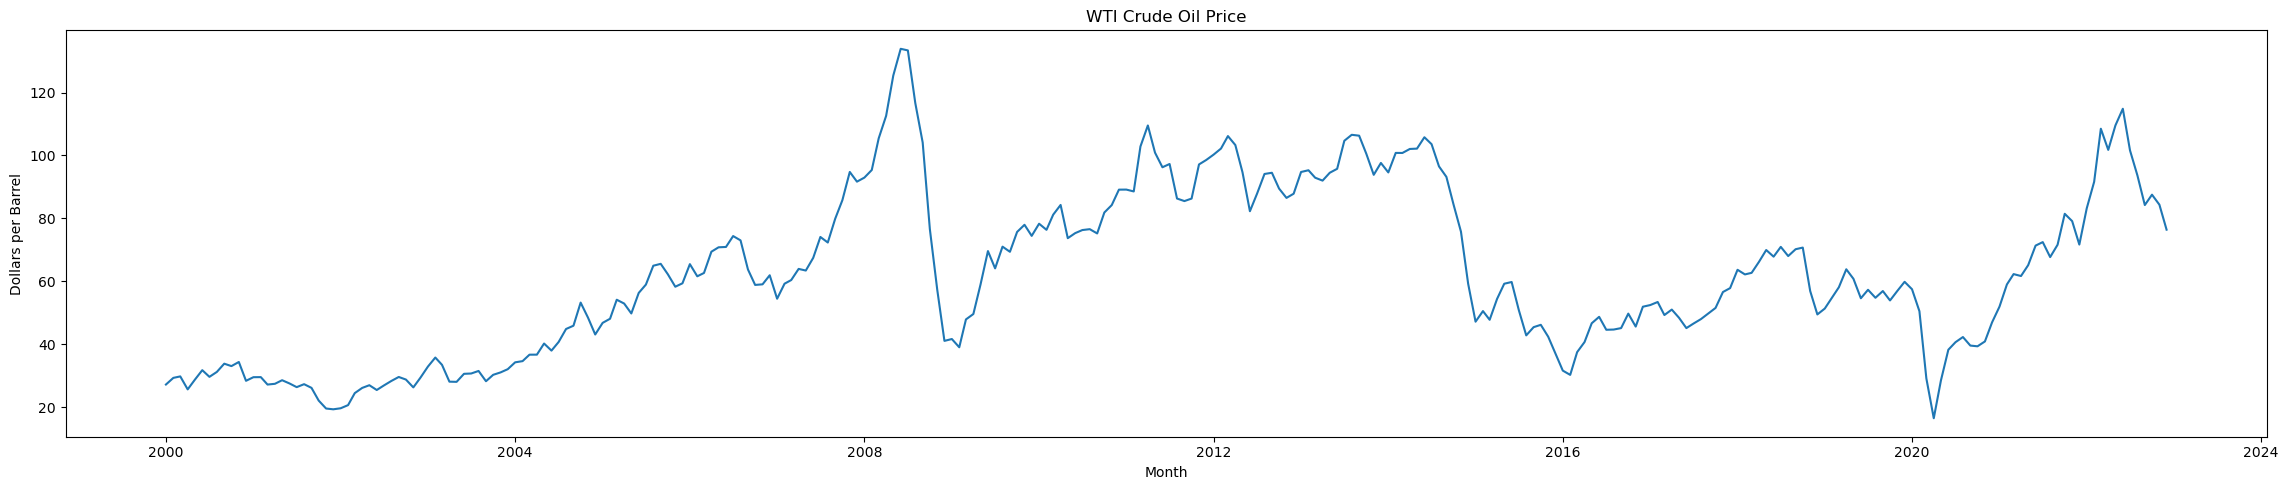

<Figure size 2500x700 with 0 Axes>

In [6]:
price_time_series_plot(wti_oil_price,'Cushing OK WTI Spot Price FOB Dollars per Barrel', 'Dollars per Barrel', 'WTI Crude Oil Price')

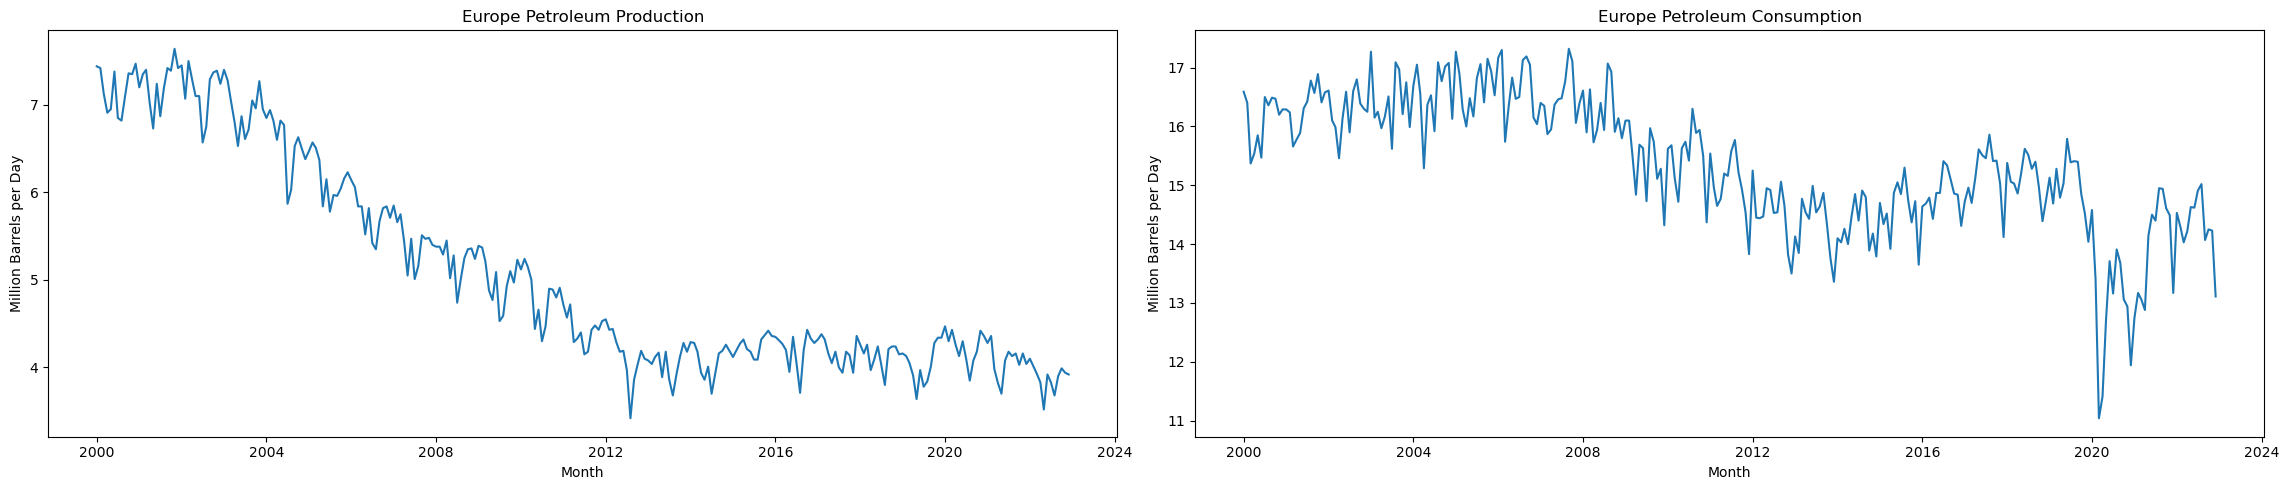

In [7]:
production_consumption_time_series_plot(europe_production,europe_consumption,'Europe Petroleum Production million barrels per day', 'Million Barrels per Day', 'Europe')

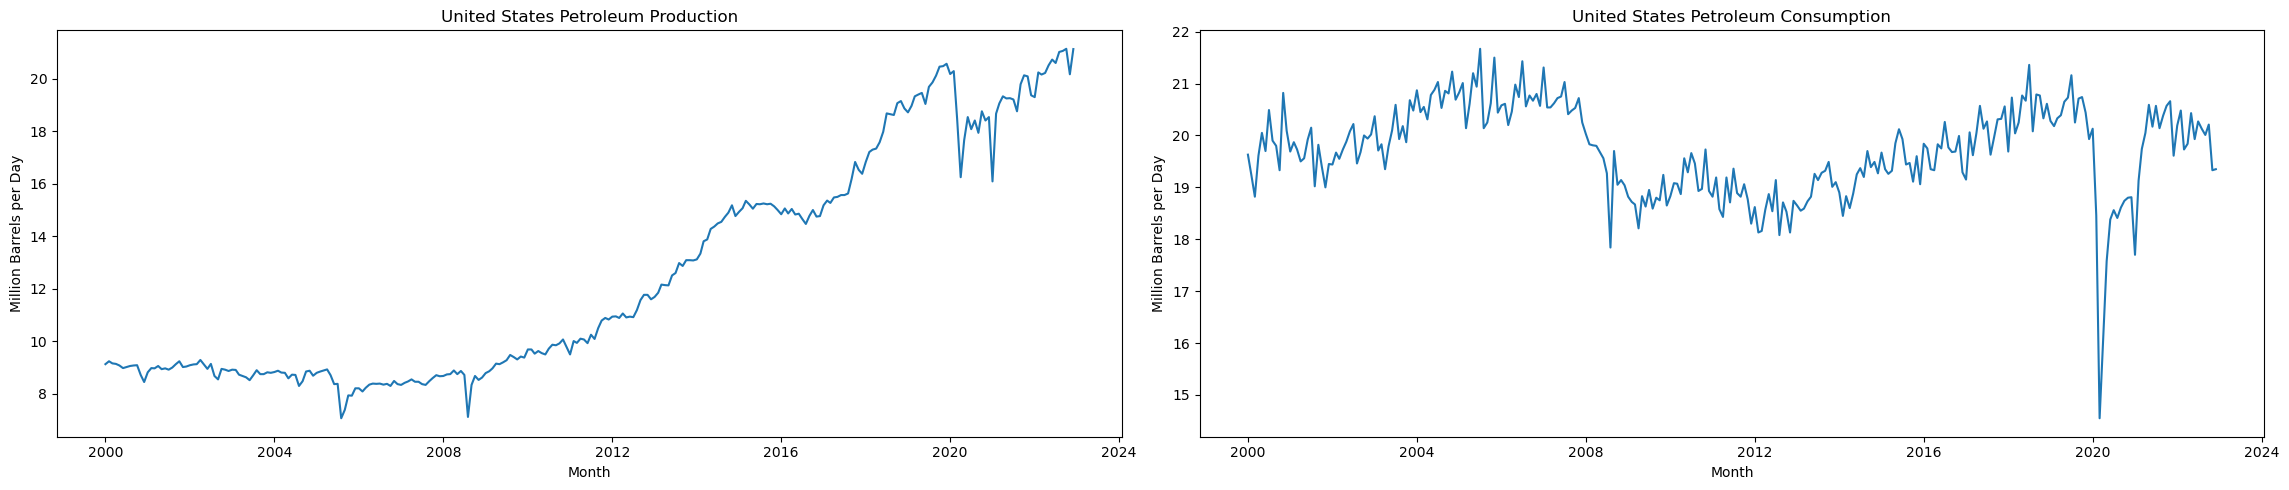

In [8]:
production_consumption_time_series_plot(us_production,us_consumption,'United States Petroleum Production million barrels per day', 'Million Barrels per Day', 'United States')

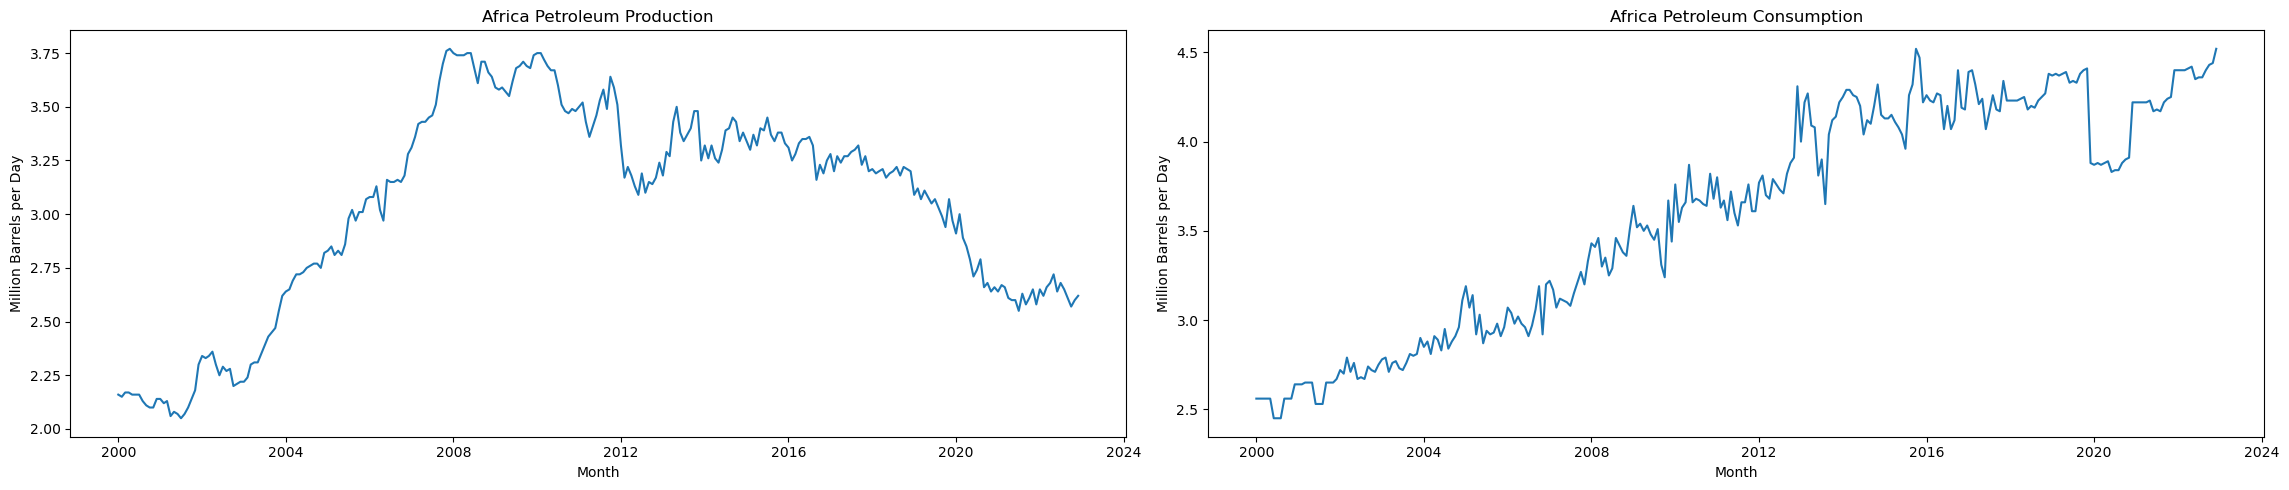

In [9]:
production_consumption_time_series_plot(africa_production,africa_consumption,'Africa Petroleum Production million barrels per day', 'Million Barrels per Day', 'Africa')

The visualizations show that the 'Brent Crude Oil Price' reflects similar peaks and trends with the 'WTI Crude Oil Price', indicating a strong correlation. Further, regional production and consumption patterns shows different fluctuations and trends for each region, which could be assessed to identify the supply-demand dynamics influencing global oil prices.

# Univariate Analysis

We attempt to create a model using univariate forecasting with ARIMA and Auto ARIMA. We begin by splitting the 'Brent Crude Oil Price' data into training and validation datasets, with data from 2022 onwards assigned as the validation set. This validation dataset will later be used to evaluate the forecasting results with the actual values.

In [10]:
# splitting data for training / validation
brent_oil_price_train = brent_oil_price_univariate[brent_oil_price_univariate.index.year <= 2022]
brent_oil_price_valid = brent_oil_price_univariate[brent_oil_price_univariate.index.year > 2022]

print('Train dataset shape:', brent_oil_price_train.shape)
print('Validation dataset shape:', brent_oil_price_valid.shape)

Train dataset shape: (428, 1)
Validation dataset shape: (24, 1)


Next, we need to ensure the dataset is stationary before feeding it into the model, as the ARIMA model relies on the assumption that the underlying time series is stationary. We implement the ADF hypothesis test with the null hypothesis that the series is non-stationary.

In [11]:
# applying ADF test to check the data stationary
adfuller_test(brent_oil_price_train["Europe Brent Spot Price FOB Dollars per Barrel"], name="Brent Oil Price")

 Augmented Dickey-Fuller Test on "Brent Oil Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.6840306789593837
 => P-Value = 0.43935856321825995
 => Series is Non-Stationary.


From the result, it shows that the initial dataset is not stationary; therefore, we will difference the data.

In [12]:
# implementing differentiation to make the data stationary
brent_oil_price_train_diff = brent_oil_price_train.diff().dropna()
adfuller_test(brent_oil_price_train_diff["Europe Brent Spot Price FOB Dollars per Barrel"], name="Brent Oil Price")

 Augmented Dickey-Fuller Test on "Brent Oil Price" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -9.449373337469833
 => P-Value = 4.660939932867418e-16 Rejecting Null Hypothesis.
 => Series is Stationary.


After the first differencing, it shows that the result is stationary; therefore, we can proceed to the forecasting modeling. Here, we plot the ACF and PACF to identify the order (`p`, `q`) of the ARIMA model.

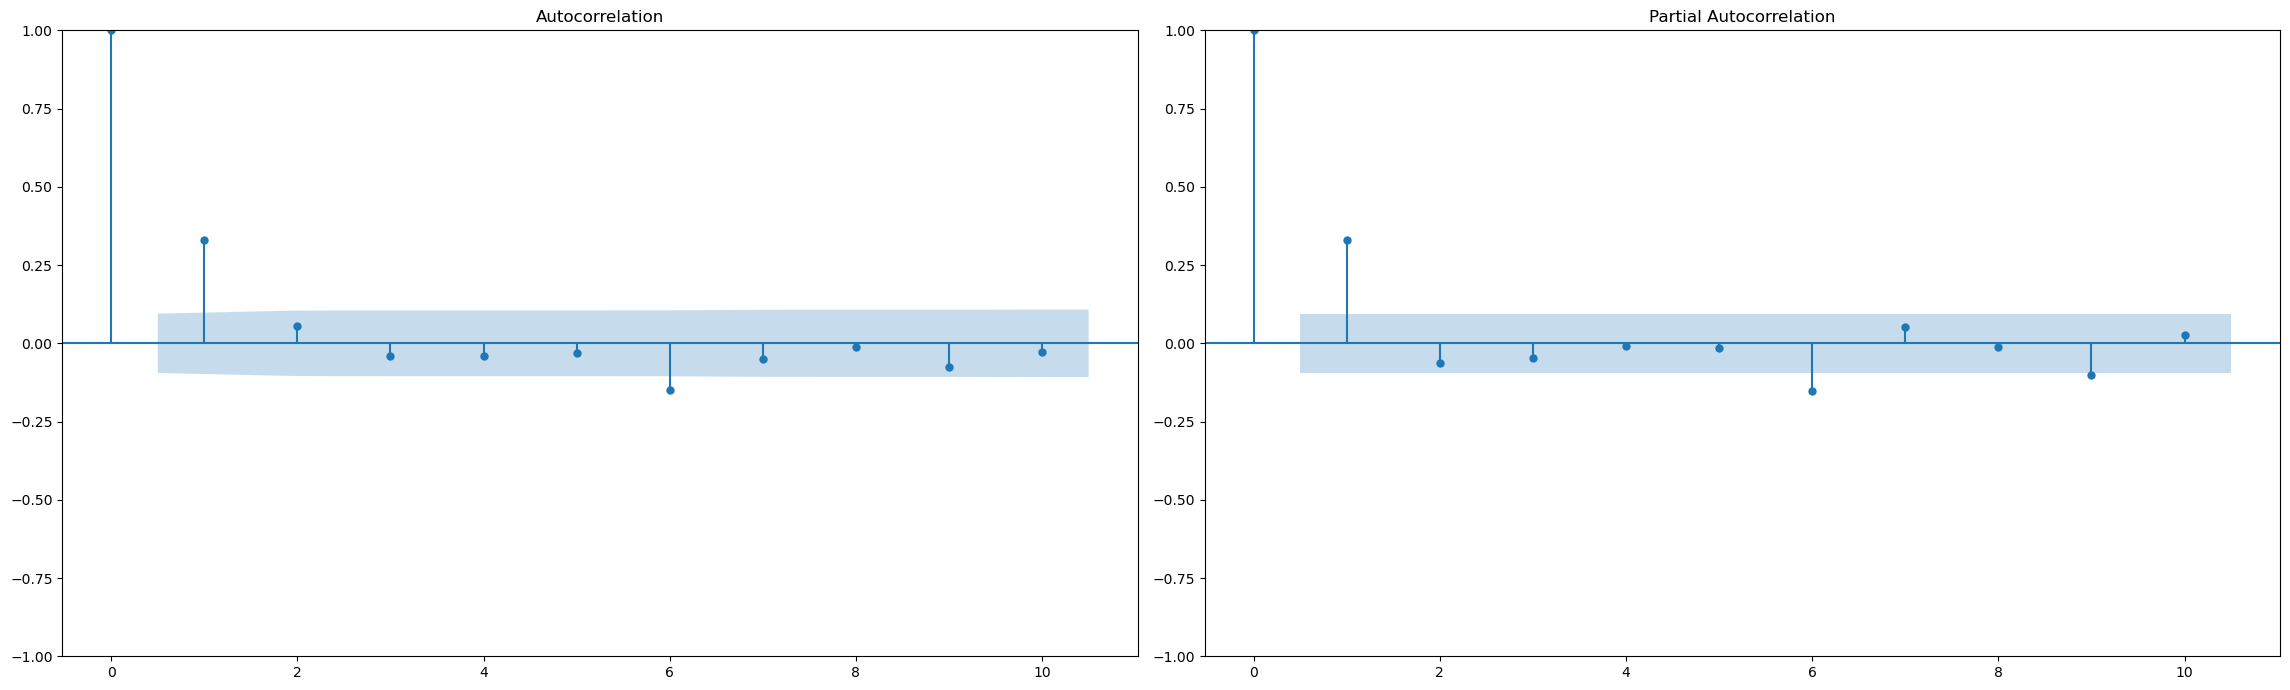

In [13]:
# plot ACF and PACF
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(23, 7))
plot_acf(brent_oil_price_train_diff["Europe Brent Spot Price FOB Dollars per Barrel"], lags=10, ax=ax1)
plot_pacf(brent_oil_price_train_diff["Europe Brent Spot Price FOB Dollars per Barrel"], lags=10, ax=ax2)
plt.tight_layout()
plt.show()

From the ACF plot, we observe a lag of 2, and from the PACF plot, we observe a lag of 1. Therefore, we will model using `ARIMA(1,1,2)` and compare it with AutoARIMA.

In [14]:
# fit model ARIMA
arima_ts = brent_oil_price_train_diff['Europe Brent Spot Price FOB Dollars per Barrel']
p, d, q = 1, 1, 2
arima_model = ARIMA(order=(p, d, q))
arima_model_fit = arima_model.fit(arima_ts)
print("Model: ARIMA(", p, d, q, ")")
print("AIC:", arima_model_fit.aic())
print("BIC:", arima_model_fit.bic())


Model: ARIMA( 1 1 2 )
AIC: 2553.4320195128394
BIC: 2573.7042162441862


In [15]:
# fit model Auto ARIMA
auto_arima_ts = brent_oil_price_train['Europe Brent Spot Price FOB Dollars per Barrel']
auto_arima_model = auto_arima(auto_arima_ts,
                   start_p=0, max_p=5,
                   start_q=0, max_q=5,
                   d=1,               # Data consumed is the original data
                   seasonal=False,    # No Seasonality
                   stepwise=False,    # Run all combinations
                   trace=False)    

auto_arima_model_fit = auto_arima_model.fit(auto_arima_ts)
print("Best Model: ARIMA", auto_arima_model_fit.order)
print("AIC:", auto_arima_model_fit.aic())
print("BIC:", auto_arima_model_fit.bic())

Best Model: ARIMA (3, 1, 2)
AIC: 2546.389568355915
BIC: 2574.787056448515


In [16]:
# forecast using both models
arima_forecast = arima_model_fit.predict(n_periods=24)
auto_arima_forecast = auto_arima_model_fit.predict(n_periods=24)

In [17]:
# invert differencing to get forecasts in the original scale
invert_arima_forecast = invert_differentiation(brent_oil_price_train, arima_forecast, 'Europe Brent Spot Price FOB Dollars per Barrel')

# evaluate forecast
evaluate_forecast("ARIMA", brent_oil_price_valid['Europe Brent Spot Price FOB Dollars per Barrel'], invert_arima_forecast)
evaluate_forecast("Auto ARIMA", brent_oil_price_valid['Europe Brent Spot Price FOB Dollars per Barrel'], auto_arima_forecast)

Model: ARIMA
MAE: 5.469304665857668
MSE: 44.59959281484321
RMSE: 6.678292657172431 

Model: Auto ARIMA
MAE: 4.8203980129357085
MSE: 34.53594460922147
RMSE: 5.876729074002091 



It is apparent from the evaluation score that AutoARIMA has a better RMSE score, which indicates that the model performs better. This suggests that AutoARIMA is more accurate in forecasting compared to the ARIMA(1,1,2) model, as it minimizes the error between the predicted and actual values more effectively. 

In [18]:
# define timestamp to the forecast result
auto_arima_df = pd.DataFrame(auto_arima_forecast.values, columns=['Europe Brent Spot Price FOB Dollars per Barrel'])
auto_arima_df['Month'] = pd.date_range(start='2023-01-01', periods=24, freq='MS')
auto_arima_df = auto_arima_df.set_index('Month')

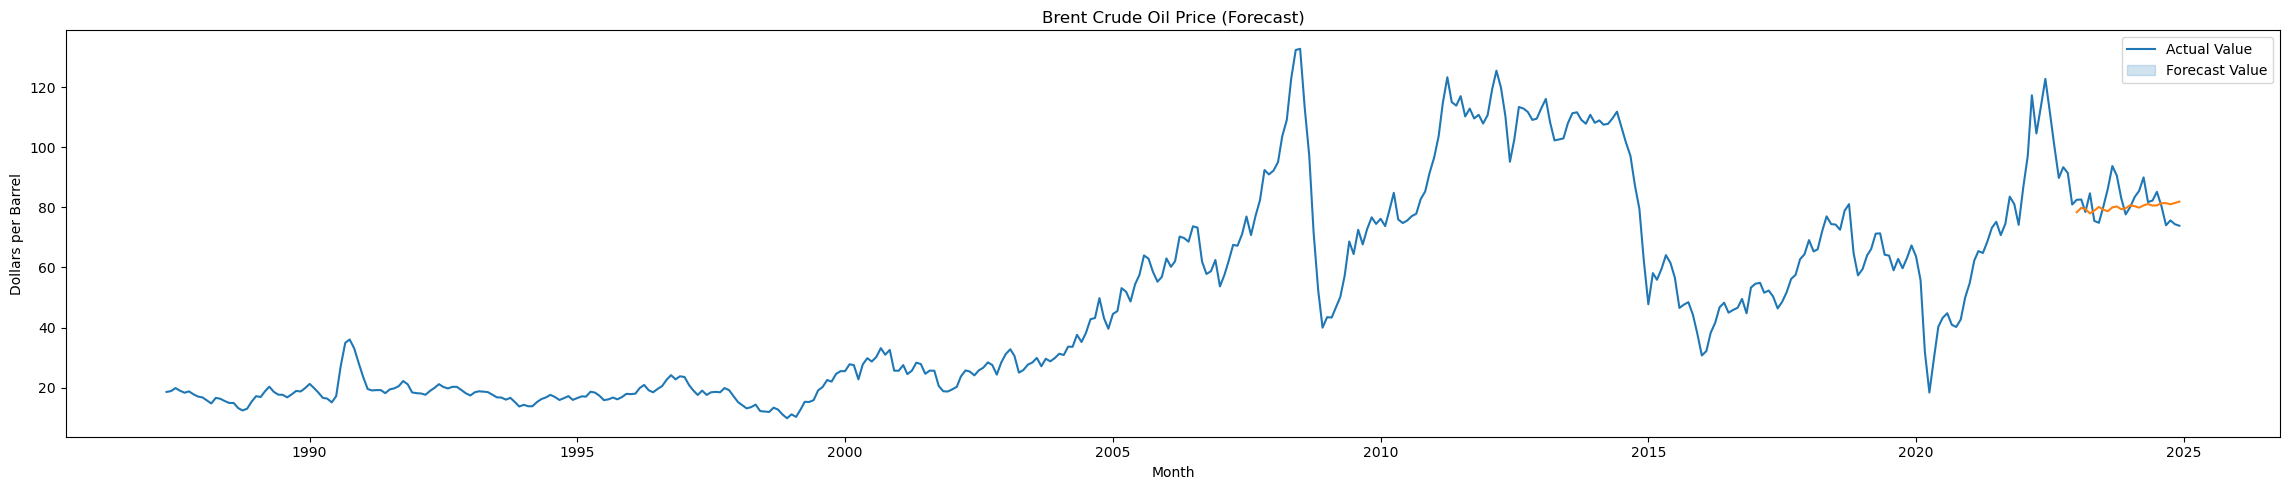

<Figure size 2500x700 with 0 Axes>

In [19]:
# visualize forecast
price_time_series_plot(brent_oil_price,'Europe Brent Spot Price FOB Dollars per Barrel', 'Dollars per Barrel', 'Brent Crude Oil Price (Forecast)',True,auto_arima_df)

# Multivariate Analysis

We continue the modeling with multivariate analysis to utilize other variables to improve the model. Similar to the univariate model, we begin by splitting the dataset into training and validation sets.

In [20]:
# splitting data for training / validation
brent_oil_price_train_v2 = brent_oil_price_multivariate[brent_oil_price_multivariate.index.year <= 2022]
brent_oil_price_valid_v2 = brent_oil_price_multivariate[brent_oil_price_multivariate.index.year > 2022]

In [21]:
# combining each variable into one dataframe
ts_multivariate = pd.concat([brent_oil_price_train_v2.iloc[:,0], 
                             wti_oil_price.iloc[:,0],
                             europe_consumption.iloc[:,0],
                             europe_production.iloc[:,0],
                             us_consumption.iloc[:,0],
                             us_production.iloc[:,0],
                             africa_consumption.iloc[:,0],
                             africa_production.iloc[:,0]],
                             axis=1)
ts_multivariate.head()

,Europe Brent Spot Price FOB Dollars per Barrel,Cushing OK WTI Spot Price FOB Dollars per Barrel,Europe Petroleum Consumption million barrels per day,Europe Petroleum Production million barrels per day,United States Petroleum Consumption million barrels per day,United States Petroleum Production million barrels per day,Africa Petroleum Consumption million barrels per day,Africa Petroleum Production million barrels per day
Month,,,,,,,,
2000-01-01,25.51,27.26,16.59,7.44,19.63,9.13,2.56,2.16
2000-02-01,27.78,29.37,16.40,7.42,19.22,9.24,2.56,2.15
2000-03-01,27.49,29.84,15.37,7.13,18.82,9.16,2.56,2.17
2000-04-01,22.76,25.72,15.54,6.91,19.61,9.14,2.56,2.17
2000-05-01,27.74,28.79,15.85,6.95,20.05,9.08,2.56,2.16


We then check the stationarity of each variable before starting the modeling process.

In [22]:
# check the stationary in the other variables using ADF test
for i in ts_multivariate.columns:
    adfuller_test(ts_multivariate[i], name=i)

 Augmented Dickey-Fuller Test on "Europe Brent Spot Price FOB Dollars per Barrel" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.6100568202397785
 => P-Value = 0.09093649035961421
 => Series is Non-Stationary.
 Augmented Dickey-Fuller Test on "Cushing OK WTI Spot Price FOB Dollars per Barrel" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.8496389170789542
 => P-Value = 0.05152555902456646
 => Series is Non-Stationary.
 Augmented Dickey-Fuller Test on "Europe Petroleum Consumption million barrels per day" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -1.6364525292186638
 => P-Value = 0.46411504431020906
 => Series is Non-Stationary.
 Augment

Based on the results, only 'US Petroleum Consumption' has stationary data. However, we will apply differencing to all variables for consistency and to maintain the same timestamps across the dataset. This avoids misalignment in time-series data caused by having variables in different forms.

In [23]:
# implementing differentiation to make the data stationary
ts_multivariate_diff = ts_multivariate.diff().dropna()

# checking the stationary in the differentiated data
for i in ts_multivariate_diff.columns:
    adfuller_test(ts_multivariate_diff[i], name=i)

 Augmented Dickey-Fuller Test on "Europe Brent Spot Price FOB Dollars per Barrel" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.653095236809103
 => P-Value = 2.0152429371794372e-21 Rejecting Null Hypothesis.
 => Series is Stationary.
 Augmented Dickey-Fuller Test on "Cushing OK WTI Spot Price FOB Dollars per Barrel" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -11.402206184683278
 => P-Value = 7.599653193058635e-21 Rejecting Null Hypothesis.
 => Series is Stationary.
 Augmented Dickey-Fuller Test on "Europe Petroleum Consumption million barrels per day" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -4.038363726014118
 => P-Value = 0.001222

After each variable is stationary, we will check the correlation between each variable and the target variable, 'Brent Crude Oil Price,' using the Granger Causality test with the null hypothesis that 'external variables do not cause the target variable.

In [24]:
grangers_causation_test(ts_multivariate_diff, ts_multivariate_diff.columns,'Europe Brent Spot Price FOB Dollars per Barrel') 

,Europe Brent Spot Price FOB Dollars per Barrel,Cushing OK WTI Spot Price FOB Dollars per Barrel,Europe Petroleum Consumption million barrels per day,Europe Petroleum Production million barrels per day,United States Petroleum Consumption million barrels per day,United States Petroleum Production million barrels per day,Africa Petroleum Consumption million barrels per day,Africa Petroleum Production million barrels per day
0,1.0,0.187,0.148,0.2171,0.1153,0.0178,0.1308,0.4026


From the results, it shows that US Petroleum Production is the only variable with a p-value smaller than 0.05, indicating that it Granger-causes the target variable. From here, we will create a VAR model using the important variables as well as all variables to compare and determine which one has better model performance.

In [25]:
# select the order or number of lag of VAR model
# best-fitted lag number found at 2
var_granger = VAR(ts_multivariate_diff[['Europe Brent Spot Price FOB Dollars per Barrel', 'United States Petroleum Production million barrels per day']])
var_order = var_granger.select_order(maxlags=10)
var_order.summary()

,AIC,BIC,FPE,HQIC
0,1.868,1.895,6.475,1.879
1,1.745,1.826*,5.726,1.778*
2,1.736*,1.872,5.677*,1.791
3,1.744,1.933,5.719,1.820
4,1.771,2.014,5.875,1.868
5,1.784,2.081,5.954,1.903
6,1.775,2.126,5.903,1.916
7,1.800,2.205,6.048,1.962
8,1.825,2.284,6.202,2.009
9,1.787,2.301,5.977,1.994


In [26]:
# fitting the model at lag 2
var_granger_model = var_granger.fit(maxlags=2)

# forecast
var_granger_forecast = var_granger_model.forecast(y=ts_multivariate_diff[['Europe Brent Spot Price FOB Dollars per Barrel', 'United States Petroleum Production million barrels per day']].values[-2:], steps=24)

# invert differencing to get forecasts in the original scale
invert_var_granger_forecast = invert_differentiation(brent_oil_price_train_v2, var_granger_forecast[:,0], 'Europe Brent Spot Price FOB Dollars per Barrel')

# evaluate forecast
evaluate_forecast("VAR Granger Causality", brent_oil_price_valid_v2['Europe Brent Spot Price FOB Dollars per Barrel'].reset_index(drop=True), invert_var_granger_forecast)

Model: VAR Granger Causality
MAE: 5.698987844383379
MSE: 48.359752976327265
RMSE: 6.95411769934384 



In [27]:
# select the order or number of lag of VAR model using all variable
# best-fitted lag number found at 2
var_all_variable = VAR(ts_multivariate_diff)
var_all_variable_order = var_all_variable.select_order(maxlags=10)
var_all_variable_order.summary()

,AIC,BIC,FPE,HQIC
0,-12.49,-12.38*,3.761e-06,-12.45
1,-13.22,-12.25,1.807e-06,-12.83*
2,-13.24*,-11.40,1.777e-06*,-12.50
3,-13.17,-10.47,1.919e-06,-12.08
4,-13.09,-9.521,2.093e-06,-11.65
5,-13.09,-8.660,2.106e-06,-11.31
6,-13.01,-7.713,2.321e-06,-10.88
7,-13.01,-6.848,2.367e-06,-10.53
8,-12.99,-5.963,2.483e-06,-10.17
9,-13.03,-5.144,2.459e-06,-9.863


In [28]:
# fitting the model at lag 2
var_all_variable_model = var_all_variable.fit(maxlags=2)

# forecast
var_all_variable_forecast = var_all_variable_model.forecast(y=ts_multivariate_diff.values[-2:], steps=24)

# invert differencing to get forecasts in the original scale
invert_var_all_variable_forecast = invert_differentiation(brent_oil_price_train_v2, var_all_variable_forecast[:,0], 'Europe Brent Spot Price FOB Dollars per Barrel')

# evaluate forecast
evaluate_forecast("VAR with All Variable", brent_oil_price_valid_v2['Europe Brent Spot Price FOB Dollars per Barrel'].reset_index(drop=True), invert_var_all_variable_forecast)

Model: VAR with All Variable
MAE: 5.1394953615390255
MSE: 40.0910337882604
RMSE: 6.3317480831331565 



From here, we see that the evaluation scores between the two models do not differ much. It shows that the model with only the Granger-causing variables for the target value is better, even though it has a higher error score, as it is more efficient and will have a shorter computation time.

In [29]:
# define timestamp to the forecast result
var_granger_df = pd.DataFrame(invert_var_granger_forecast, columns=['Europe Brent Spot Price FOB Dollars per Barrel'])
var_granger_df['Month'] = pd.date_range(start='2023-01-01', periods=24, freq='MS')
var_granger_df = var_granger_df.set_index('Month')

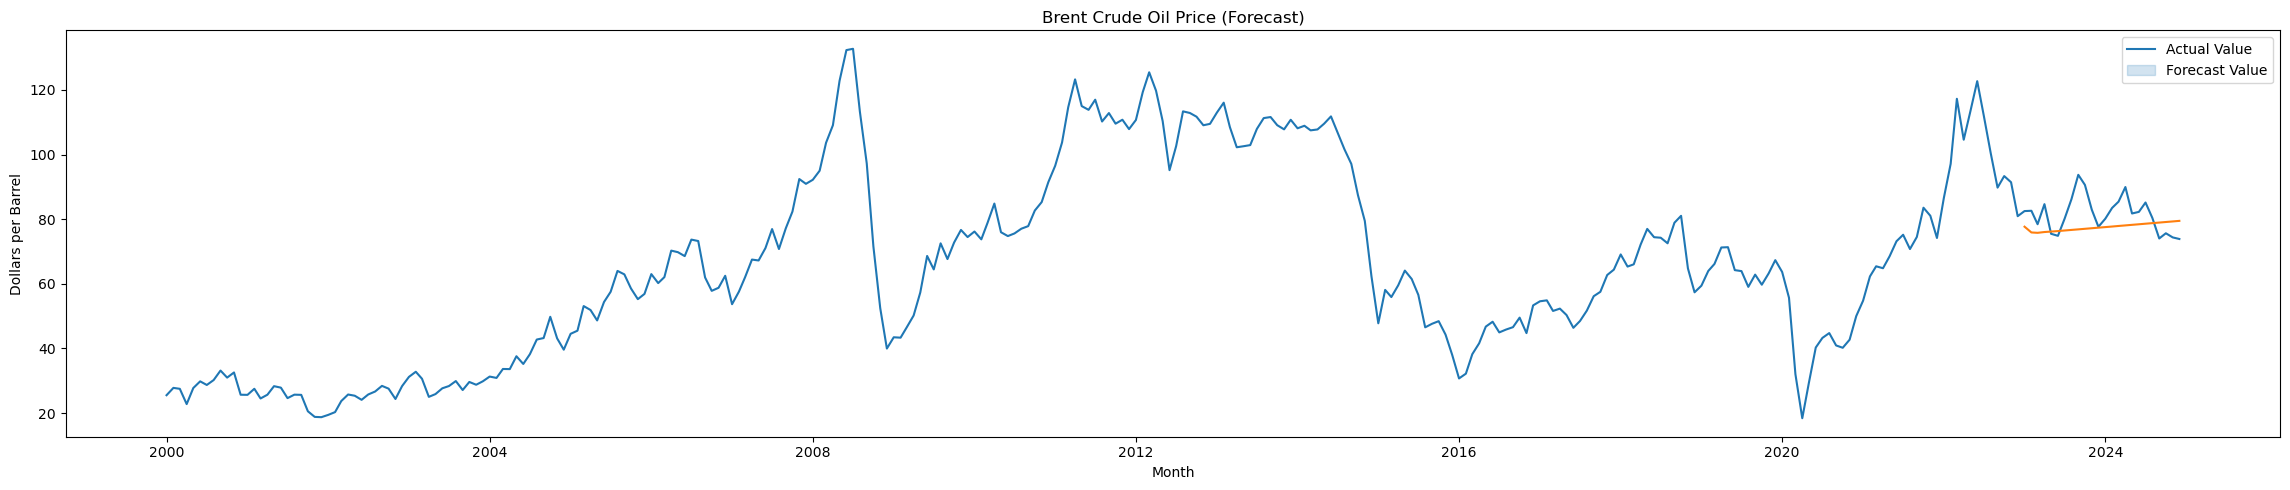

<Figure size 2500x700 with 0 Axes>

In [30]:
# visualize forecast
price_time_series_plot(brent_oil_price_multivariate, 'Europe Brent Spot Price FOB Dollars per Barrel', 'Dollars per Barrel', 'Brent Crude Oil Price (Forecast)', True, var_granger_df)

In conclusion, when we compare the performance of each model, we find that the univariate forecasting model has better performance compared to the multivariate model, with the AutoARIMA model being the best. This shows that, in this case, the inclusion of additional variables did not improve the model’s accuracy and may have introduced unnecessary complexity, resulting in longer computation times without significant gains in predictive performance.